# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N) |



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("../data/data.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [47]:
import plotly.io as pio
import plotly.express as px
df['Loan_Status'].describe()

# pio.templates

count     614
unique      2
top         Y
freq      422
Name: Loan_Status, dtype: object

In [52]:
%matplotlib widget

na_cols = df.isna().any()
na_counts = (df.isna()).sum()
na_summary = pd.DataFrame(zip(na_cols,na_counts),columns=['Has NA    |','    # of NA'],index=df.columns)
# na_summary = pd.DataFrame(zip(na_cols,na_counts),columns=['has_na','num_of_na'],index=df.columns)

na_summary.style.bar()

,Has NA | |,# of NA
Loan_ID,False,0
Gender,True,13
Married,True,3
Dependents,True,15
Education,False,0
Self_Employed,True,32
ApplicantIncome,False,0
CoapplicantIncome,False,0
LoanAmount,True,22
Loan_Amount_Term,True,14


Look at some basic statistics for numerical variables.

In [4]:
df['Loan_Status'] = [ 1 if x == "Y" else 0 for x in df['Loan_Status']]


In [5]:
# with plt.xkcd(scale=0.3,length=50,randomness=100):
fig, axs = plt.subplots(1,6,figsize=(25,7),subplot_kw={'ylabel':"Density","facecolor":"grey"},facecolor="grey")
hists = df.hist(ax=axs,bins=50,density=True,cumulative=False,color="teal",ylabelsize=10,xlabelsize=10,sharey=False,alpha=0.5)
axs[0].set_xlim(0,20000)
axs[1].set_xlim(0,20000)
axs[2].set_xlim(0,600)
axs[3].set_xlim(0,500)
axs[4].clear()
axs[5].clear()

#create pie chart

axs[4].pie([df['Credit_History'].mean(),1-df['Credit_History'].mean()], colors =['Teal','Grey'], autopct='%.0f%%')
axs[4].title = "Credit History"
axs[5].pie([df['Loan_Status'].mean(),1-df['Loan_Status'].mean()], colors =['Teal','Grey'], autopct='%.0f%%');

AttributeError: 'str' object has no attribute 'get_position'

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)
         - **84.22% of applicants have a credit history**
2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?
         - Yes.  Not 1000% sure what the actual monetary unit is here but that doesn't really matter. The coapplicant income appears to be one tail of a normal distribution (with kurtosis much higher than 3, however) , and the primary applicant income histogram is a similar graph but shifted to the right, because it seems the person applying for the loan tends to be the primary earner in the home.
3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.
         - There is significant skew to this data towards high income.  This does make some sense, however, as even if the data is generally normally distributed, there is a lower bound on income (albeit a soft-cap), but no higher bound.



Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [6]:
cats = df.T[df.dtypes == object].iloc[1:]
noms = cats.T.apply(lambda x : len(set(x)))
cats.T.apply(lambda x: pd.value_counts(x))

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,NaN,NaN,345.0,NaN,NaN,NaN
1,NaN,NaN,102.0,NaN,NaN,NaN
2,NaN,NaN,101.0,NaN,NaN,NaN
3+,NaN,NaN,51.0,NaN,NaN,NaN
Female,112.0,NaN,NaN,NaN,NaN,NaN
Graduate,NaN,NaN,NaN,480.0,NaN,NaN
Male,489.0,NaN,NaN,NaN,NaN,NaN
No,NaN,213.0,NaN,NaN,500.0,NaN
Not Graduate,NaN,NaN,NaN,134.0,NaN,NaN
Rural,NaN,NaN,NaN,NaN,NaN,179.0


Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

In [7]:
cats.T

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,Male,No,0,Graduate,No,Urban
1,Male,Yes,1,Graduate,No,Rural
2,Male,Yes,0,Graduate,Yes,Urban
3,Male,Yes,0,Not Graduate,No,Urban
4,Male,No,0,Graduate,No,Urban
...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,Rural
610,Male,Yes,3+,Graduate,No,Rural
611,Male,Yes,1,Graduate,No,Urban
612,Male,Yes,2,Graduate,No,Urban


### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



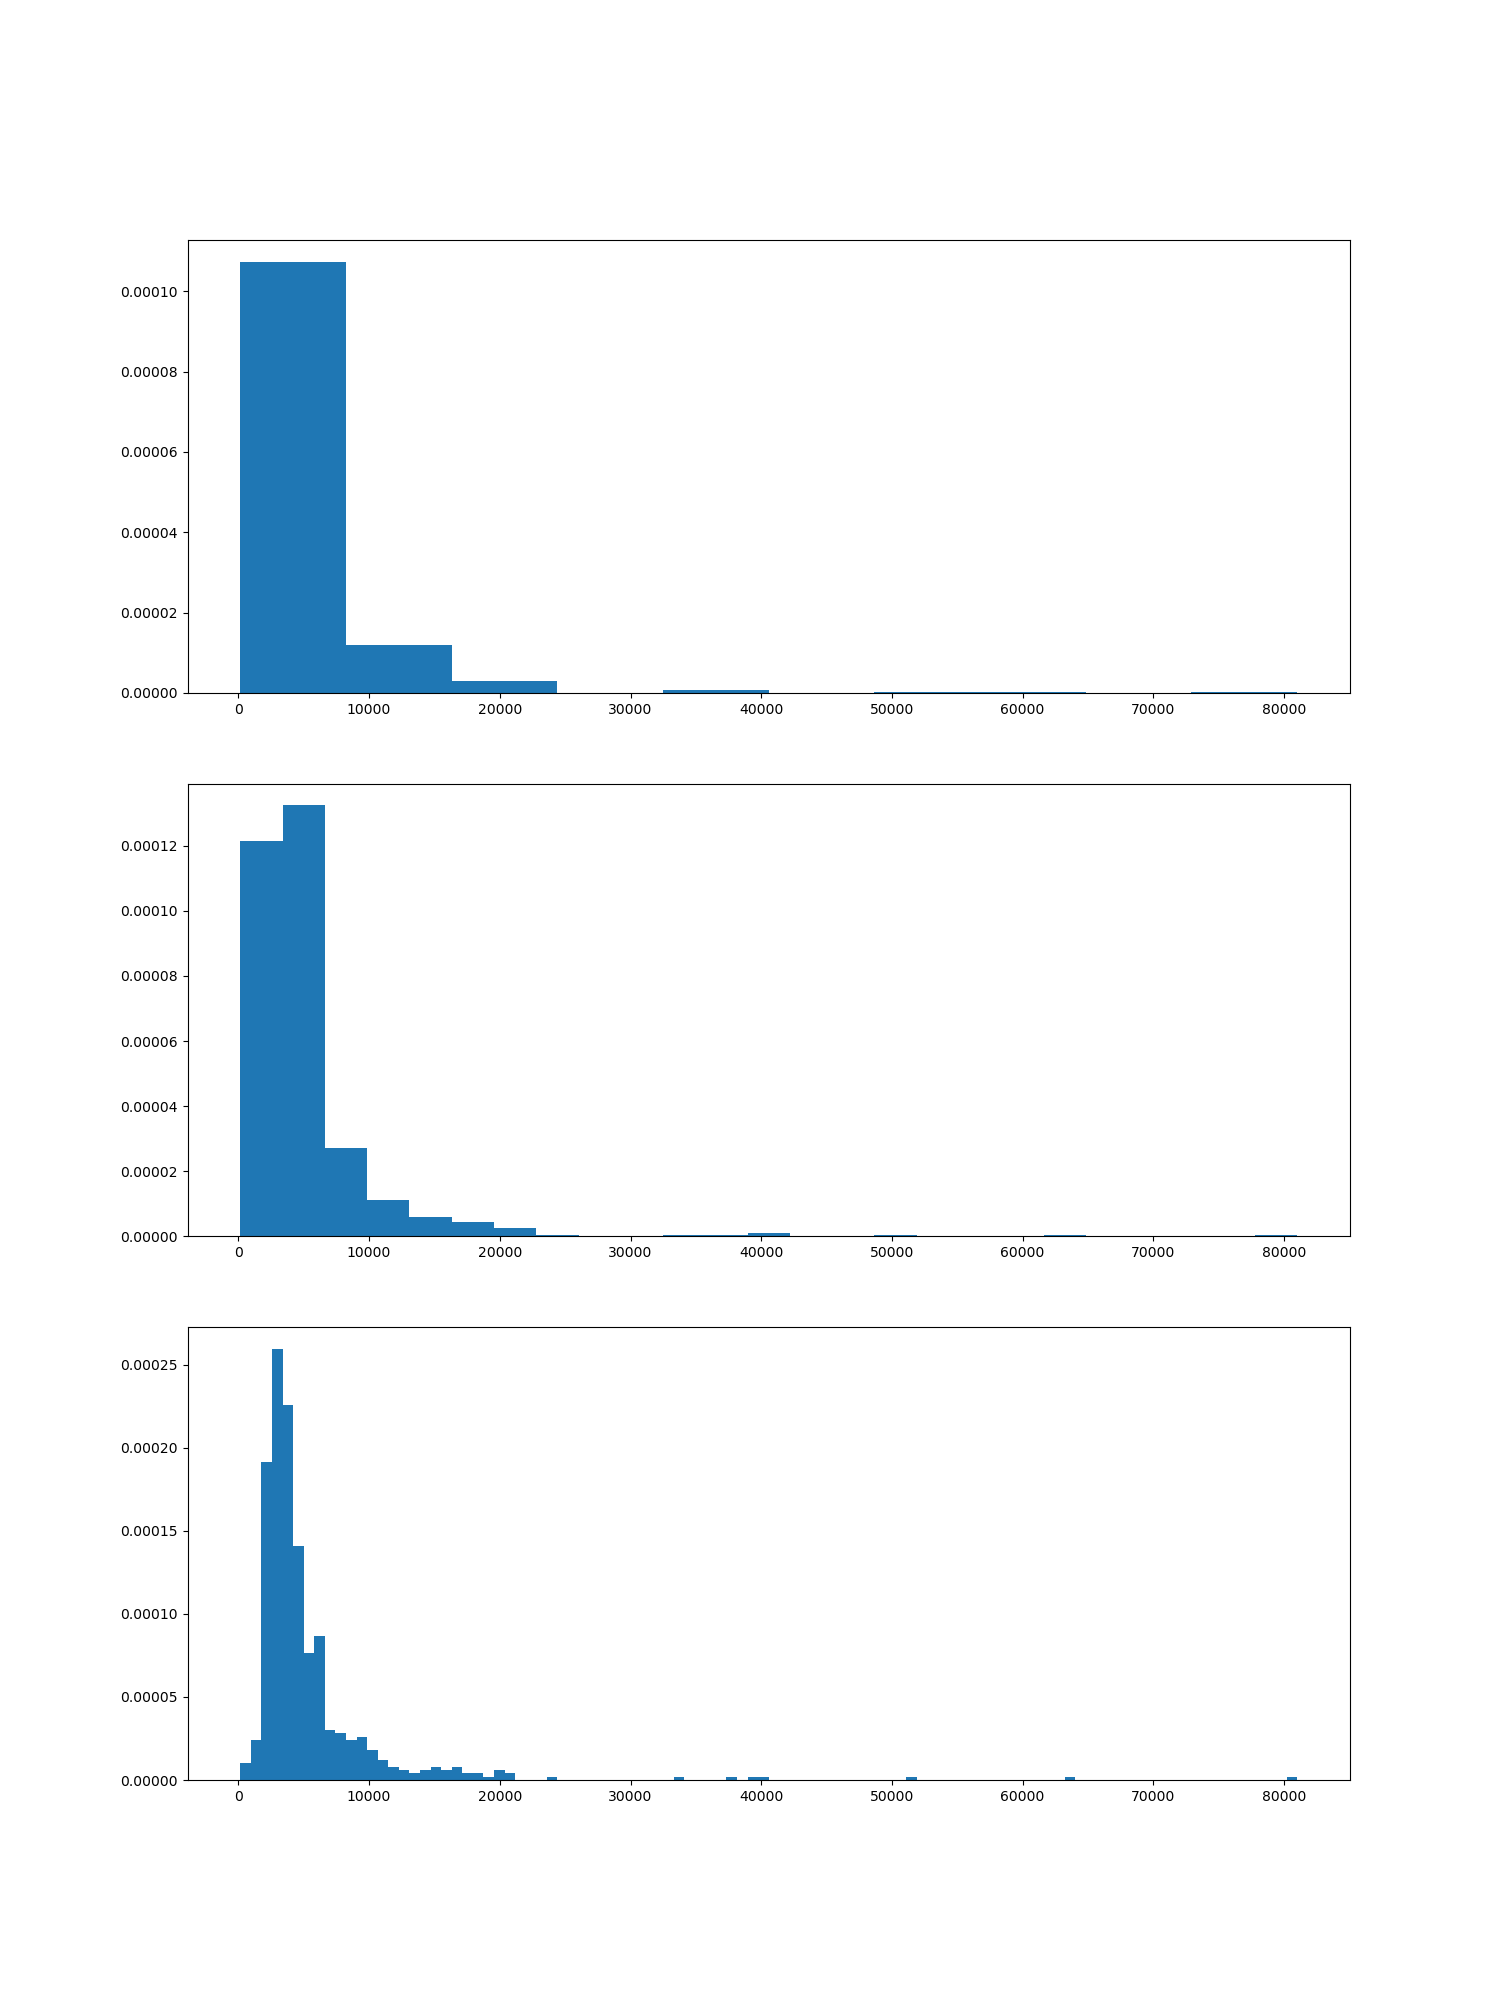

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (15,20))

ax1.hist(data=df,x='ApplicantIncome',bins=10,density=True)

ax2.hist(data=df,x='ApplicantIncome',bins=25,density=True)
ax3.hist(data=df,x='ApplicantIncome',bins=100,density=True)


plt.show()


Look at box plots to understand the distributions. 

In [10]:
import pickle
# fig, axs = plt.subplots(4,1,figsize=(10,10))
# df_numeric2 = pickle.load(open('/df_numeric2.p','rb'))
# df_numeric = pickle.load(open('/df_numeric1.p','rb'))
# sns.boxplot(data=df_numeric,x='ApplicantIncome', ax=axs[0])
# sns.boxplot(data=df_numeric,x='CoapplicantIncome', ax=axs[1])
# sns.boxplot(data=df_numeric,x='LoanAmount', ax=axs[2])
# sns.boxplot(data=df_numeric,x='Loan_Amount_Term', ax=axs[3])
# plt.tight_layout()

Look at the distribution of income segregated  by `Education`

<function matplotlib.pyplot.show(close=None, block=None)>

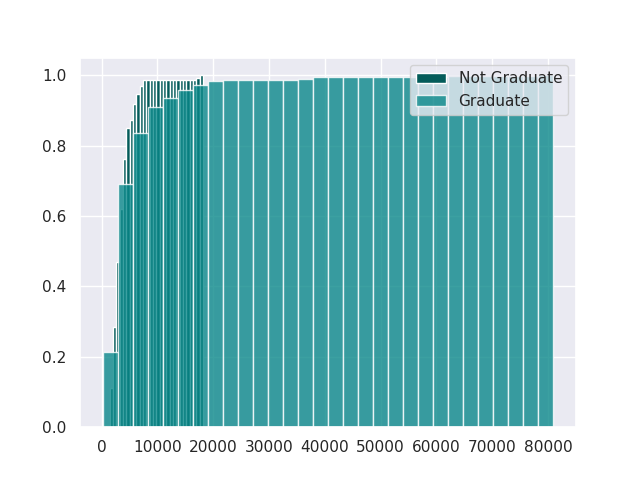

In [53]:
df_grad = df[df['Education']=="Graduate"]
df_ungrad = df[df['Education']=="Not Graduate"]

fig, ax = plt.subplots()
df_ungrad['ApplicantIncome'].hist(ax=ax,density=True,bins=30,legend=True,cumulative=True)
df_grad['ApplicantIncome'].hist(ax=ax,density=True, bins=30,legend=True,alpha=0.8,cumulative=True)
ax.legend(labels=['Not Graduate','Graduate'])
plt.show

Look at the histogram and boxplot of LoanAmount

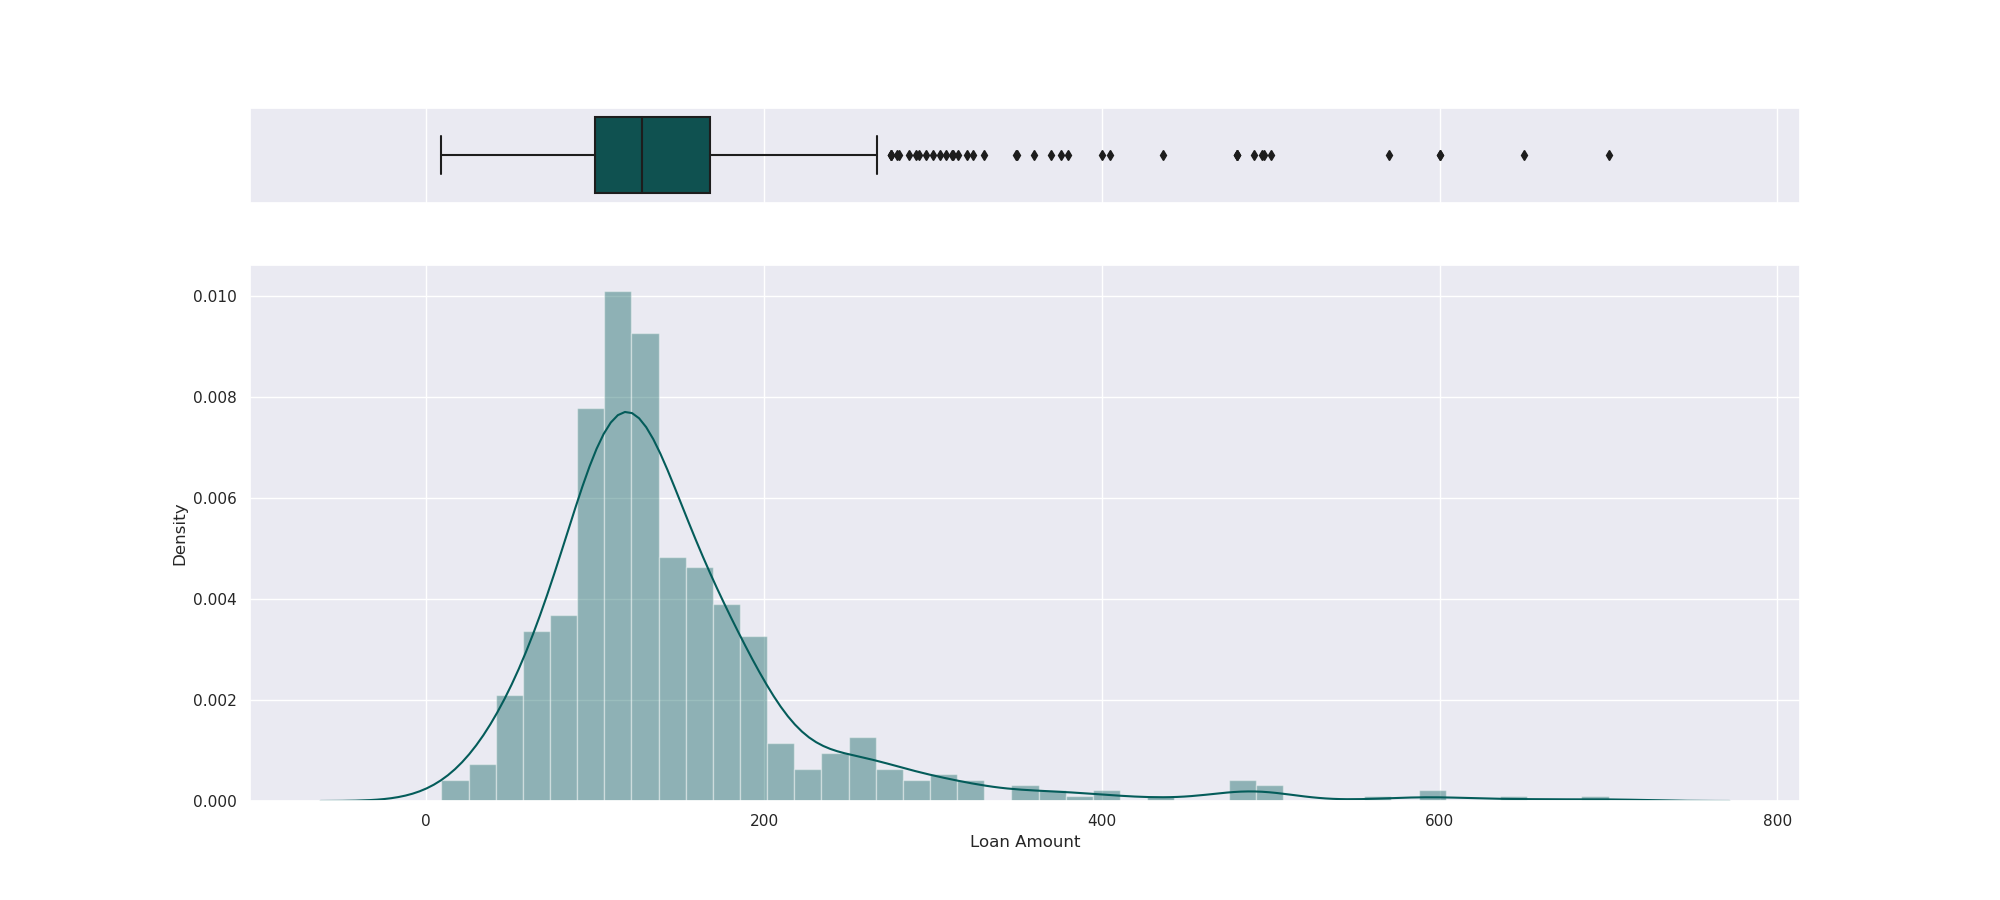

In [54]:

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(20,9), sharex='all', gridspec_kw={"height_ratios": (.15, .85)})
# Add a graph in each part
sns.boxplot(x=df["LoanAmount"], ax=ax_box)
sns.distplot(x=df["LoanAmount"], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='');
ax_hist.set(xlabel="Loan Amount");

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical variable analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

<AxesSubplot:xlabel='Gender'>

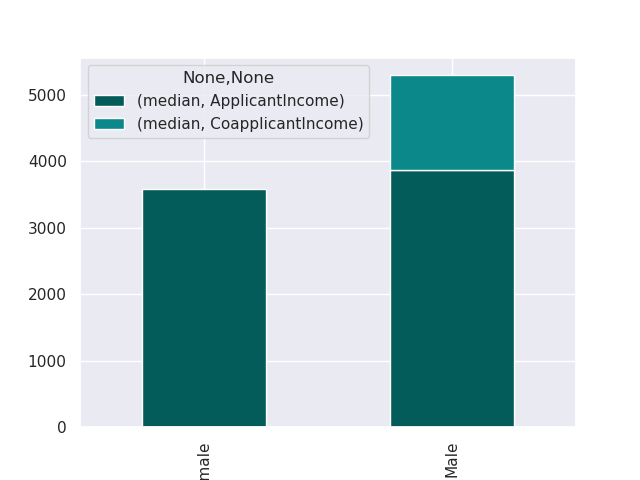

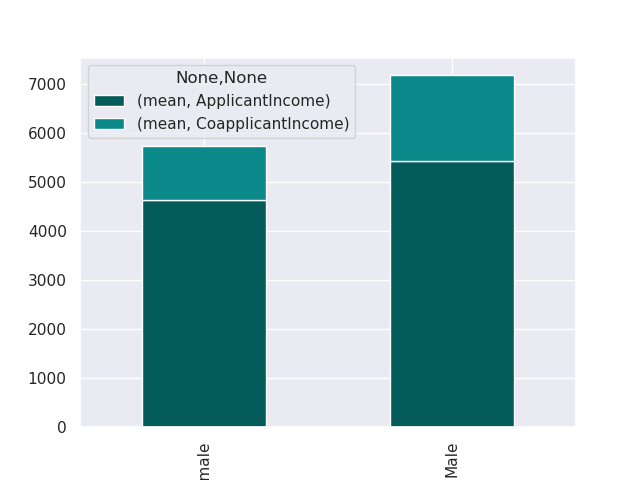

In [55]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df.pivot_table(index=['Gender'],values=['ApplicantIncome','CoapplicantIncome'],aggfunc=[np.median],fill_value=np.median).plot(kind='bar',stacked=True)
df.pivot_table(index=['Gender'],values=['ApplicantIncome','CoapplicantIncome'],aggfunc=[np.mean],fill_value=np.mean).plot(kind='bar',stacked=True)


In [56]:
df.pivot_table(index=['Gender','Education'],aggfunc=[np.mean],fill_value=np.mean).style.background_gradient()


In [57]:



# nex = df.pivot_table(index=['Gender','Education'],values=['Credit_History'],aggfunc=[np.median],dropna=True)
# fig,ax = plt.subplots(figsize=(18,9))
# sns.barplot(data=nex,x=nex.index.to_numpy(),y=nex['Credit_History'])
# nex['ApplicantIncome']

In [58]:
df.pivot_table(columns=['Gender'],index=['Dependents'],aggfunc=(lambda x: x.isna().sum()))

ApplicantIncome      CoapplicantIncome      Credit_History       \
Gender              Female Male            Female Male         Female Male   
Dependents                                                                   
0                        0    0                 0    0              8   20   
1                        0    0                 0    0              1   11   
2                        0    0                 0    0              1    5   
3+                       0    0                 0    0              1    2   

           Education      LoanAmount       ... Loan_Status      Married       \
Gender        Female Male     Female Male  ...      Female Male  Female Male   
Dependents                                 ...                                 
0                  0    0          0   11  ...           0    0       0    0   
1                  0    0          1    3  ...           0    0       0    0   
2                  0    0          0    3  ...           0    0       0    0   
3+                 0    0          1    1  ...           0    0       0    0   

           Property_Area      Self_Employed      TotalIncome       
Gender            Female Male        Female Male      Female Male  
Dependents                                                         
0                      0    0             3   16           0    0  
1                      0    0             2    4           0    0  
2                      0    0             2    3           0    0  
3+                     0    0             1    1           0    0  

[4 rows x 24 columns]

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [59]:
import missingno as msno
na_summary.style.bar()


,Has NA | |,# of NA
Loan_ID,False,0
Gender,True,13
Married,True,3
Dependents,True,15
Education,False,0
Self_Employed,True,32
ApplicantIncome,False,0
CoapplicantIncome,False,0
LoanAmount,True,22
Loan_Amount_Term,True,14


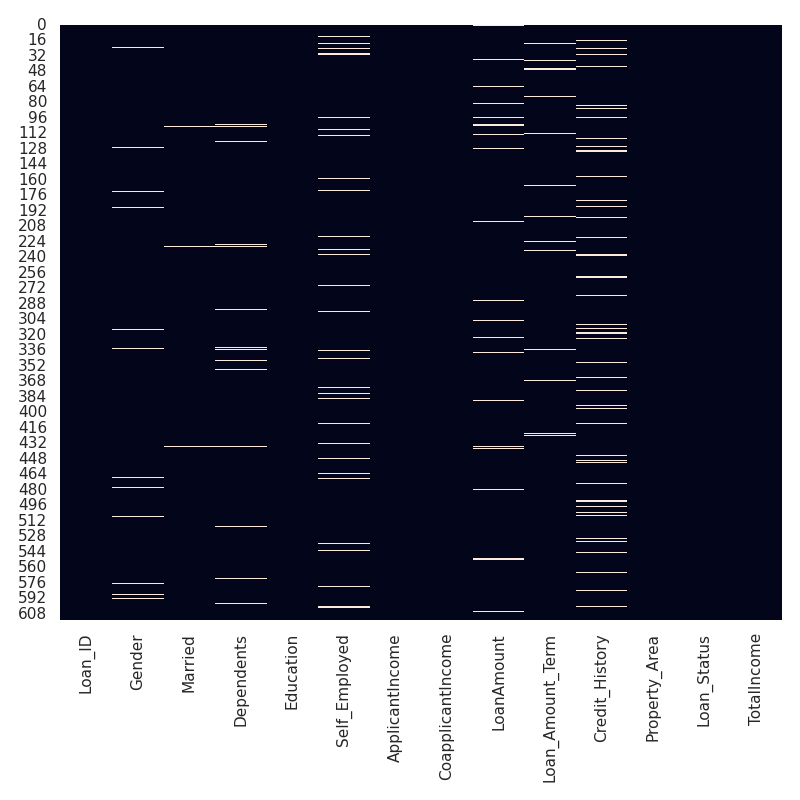

In [60]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sns.heatmap(df.isnull(),cbar=False,ax=ax)
plt.tight_layout()

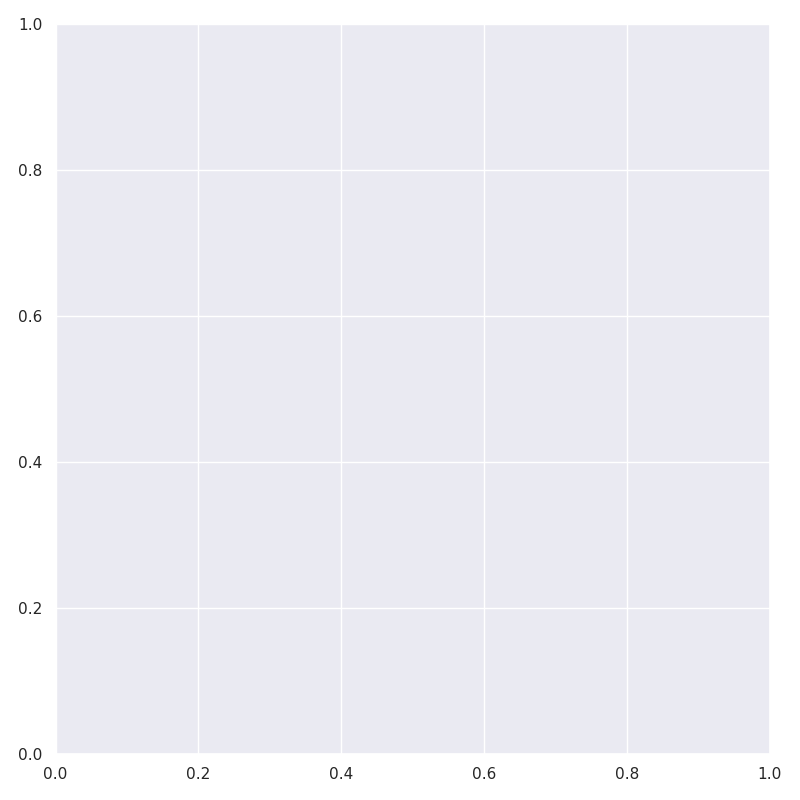

In [61]:
plt.close()
df_na = df.isna().apply(lambda x: x.apply(int))
df_na = df_na.drop('Loan_ID',axis=1)
# df_na = df_na[df_na.columns[na_summary['has_na']]]
commie = np.matmul(df_na.T, df_na)

commie[[]]
fig, ax = plt.subplots(1,1,figsize=(8,8))

plt.tight_layout()

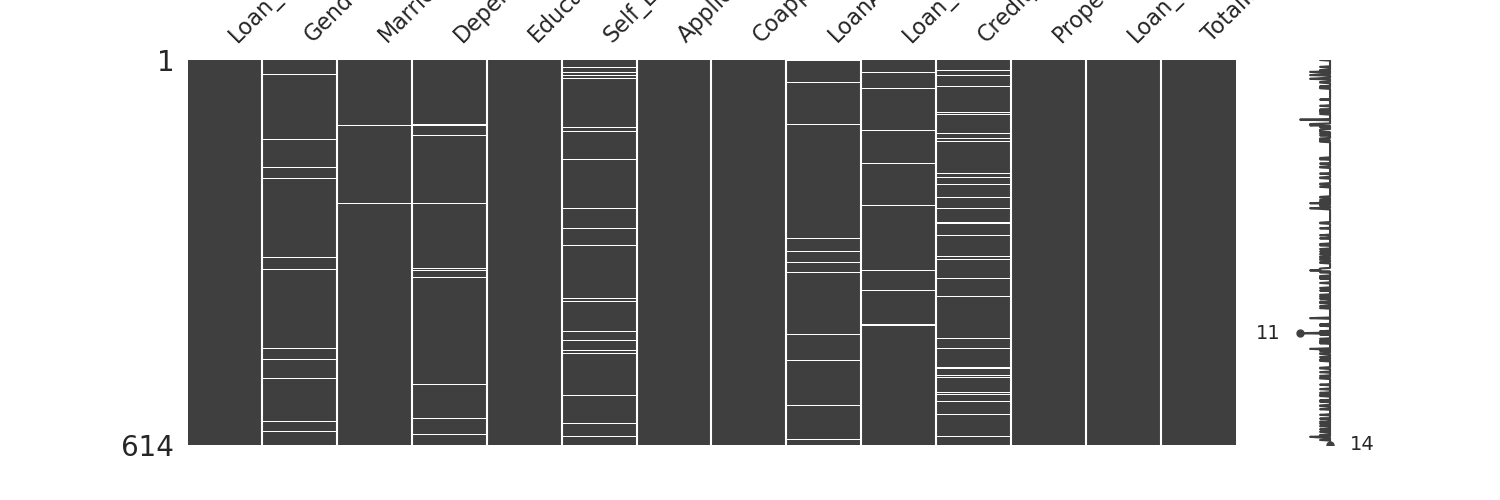

In [62]:
msno.matrix(df,sparkline=True,figsize=(15,5))
plt.tight_layout()
plt.show()

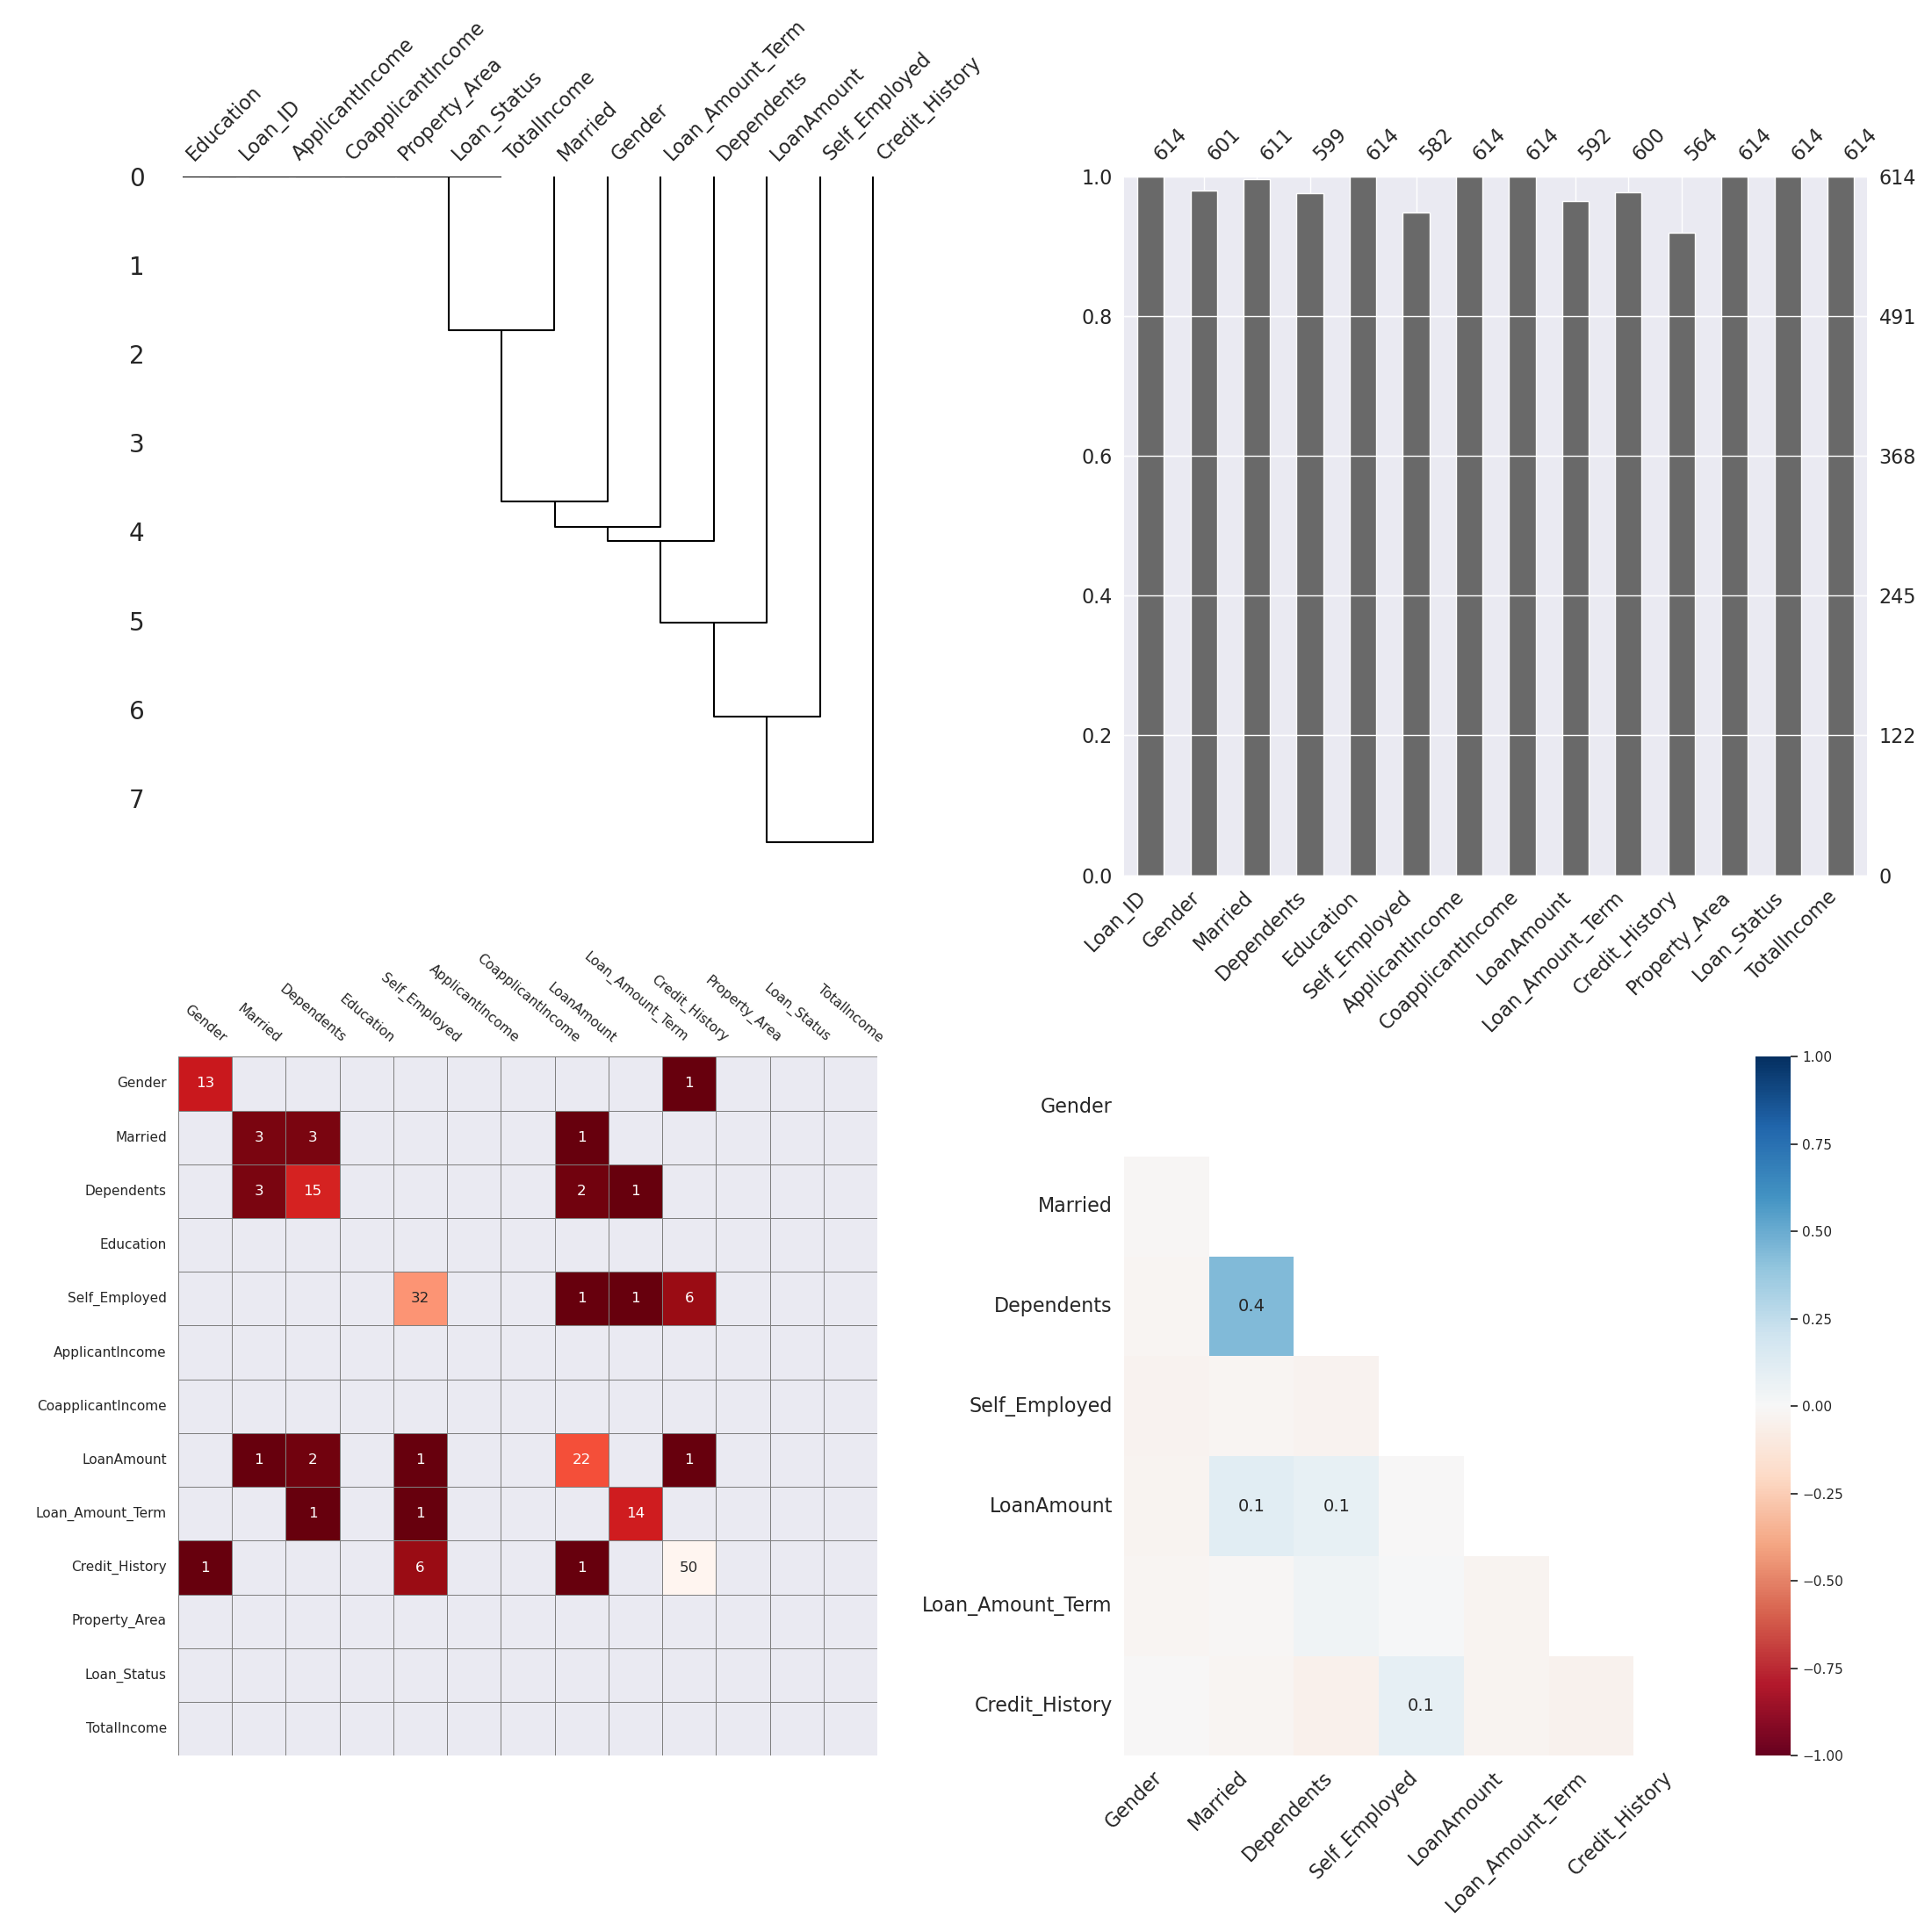

In [63]:
plt.close()
fig,ax = plt.subplots(2,2,figsize=(22,22))

sns.heatmap(data=commie, cmap='Reds_r',ax=ax[1,0],square=True,mask=(commie==0),cbar = False,annot=True,linewidths=0.5,linecolor='Grey')
ax[1,0].xaxis.tick_top()
ax[1,0].tick_params(left=False,top=False)
ax[1,0].set_xticklabels(labels = df_na.columns,rotation=320);

msno.bar(df,ax=ax[0,1])
msno.dendrogram(df,ax=ax[0,0],)
msno.heatmap(df,ax=ax[1,1])
plt.tight_layout()
plt.show()

In [64]:
from copy import deepcopy, copy
df_filled = deepcopy(df)
xxx = df_filled.pivot_table(index=['Gender','Education'],values=['Credit_History'],aggfunc=[np.mean,"count",(lambda x : np.mean(pd.isna(x))),(lambda x : np.sum(pd.isna(x)))])
xxx

mean          count       <lambda>  \
                    Credit_History Credit_History Credit_History   
Gender Education                                                   
Female Graduate           0.831325             83       0.097826   
       Not Graduate       0.833333             18       0.100000   
Male   Graduate           0.865330            349       0.071809   
       Not Graduate       0.784314            102       0.097345   

                                    
                    Credit_History  
Gender Education                    
Female Graduate                  9  
       Not Graduate              2  
Male   Graduate                 27  
       Not Graduate             11

In [65]:
import numpy.random as random
df_aux = pd.DataFrame()
df_filled['Gender_Bit'] = [1 if x =='Male' else 0 if x=='Female' else np.nan for x in df_filled['Gender']]
df_filled['Married_Bit'] = [1 if x =='Yes' else 0 if x=='No' else np.nan for x in df_filled['Married']]
df_filled['Self_Employed_Bit'] = [1 if x =='Yes' else 0 if x=='No' else np.nan for x in df_filled['Self_Employed']]
df_filled['Education_Bit'] = [1 if x =='Graduate' else 0 for x in df_filled['Education']]

dependent_categories = df_filled['Dependents'].value_counts()/df_filled['Dependents'].count()

df_aux['means'] = np.mean(df_filled)
df_filled_final = deepcopy(df)

gender_mean = df_aux['means'].loc['Gender_Bit']
credit_mean = df_aux['means'].loc['Credit_History']
married_mean = df_aux['means'].loc['Married_Bit']
employment_mean = df_aux['means'].loc['Self_Employed_Bit']

dc = dependent_categories

In [66]:
random.seed(10)
df_filled['Gender_Bit_Filled'] = [1 if x =='Male' else 0 if x=='Female' else 1 if random.uniform(0,1) < gender_mean else 0 for x in df_filled['Gender']]
df_filled['Married_Bit_Filled'] = [1 if x ==1 else 0 if x==0 else 1 if random.uniform(0,1) < married_mean else 0 for x in df_filled['Married_Bit']]
df_filled['Self_Employed_Bit_Filled'] = [int(x) if not np.isnan(x) else 1 if random.uniform(1,0) < employment_mean else 0 for x in df_filled['Self_Employed_Bit']]
df_filled['Credit_History_Filled'] = [int(x) if not np.isnan(x) else 1 if random.uniform(1,0) < credit_mean else 0 for x in df_filled['Credit_History']]

df_filled['Dependents_Filled'] = [x if not pd.isna(x) else '0' if y < dc.loc['0'] else '1' if y < dc.loc['1'] else '2' if y < dc.loc['2'] else '3+' for x,y in zip(df_filled['Dependents'],random.uniform(0,1,size=(df_filled['TotalIncome'].count())))]

term_med = df_filled['Loan_Amount_Term'].median()
amt_med = df_filled['LoanAmount'].median()

df_filled['Loan Amount_Term_Filled'] = [x if not pd.isna(x) else term_med for x in df_filled['Loan_Amount_Term']]
df_filled['LoanAmount_Filled'] = [x if not pd.isna(x) else amt_med for x in df_filled['LoanAmount']]

df_filled['LoanAmount_Filled'].isna().sum()

0

In [67]:
df_filled_final['Gender'] = df_filled['Gender_Bit_Filled']
df_filled_final['Credit_History'] = df_filled['Credit_History_Filled']
df_filled_final['Married'] = df_filled['Married_Bit_Filled']
df_filled_final['Dependents'] = df_filled['Dependents_Filled']
df_filled_final['Loan_Amount_Term'] = df_filled['Loan Amount_Term_Filled']
df_filled_final['Self_Employed'] = df_filled['Self_Employed_Bit_Filled']
df_filled_final['LoanAmount'] = df_filled['LoanAmount_Filled']
df_filled_final['Education'] = df_filled['Education_Bit']

na_cols_f = df_filled_final.isna().any()
na_counts_f = (df_filled_final.isna()).sum()
na_summary_f = pd.DataFrame(zip(na_cols_f,na_counts_f),columns=['has_na','num_of_na'],index=df.columns)
na_summary_f.style.bar()

,has_na,num_of_na
Loan_ID,False,0
Gender,False,0
Married,False,0
Dependents,False,0
Education,False,0
Self_Employed,False,0
ApplicantIncome,False,0
CoapplicantIncome,False,0
LoanAmount,False,0
Loan_Amount_Term,False,0


### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

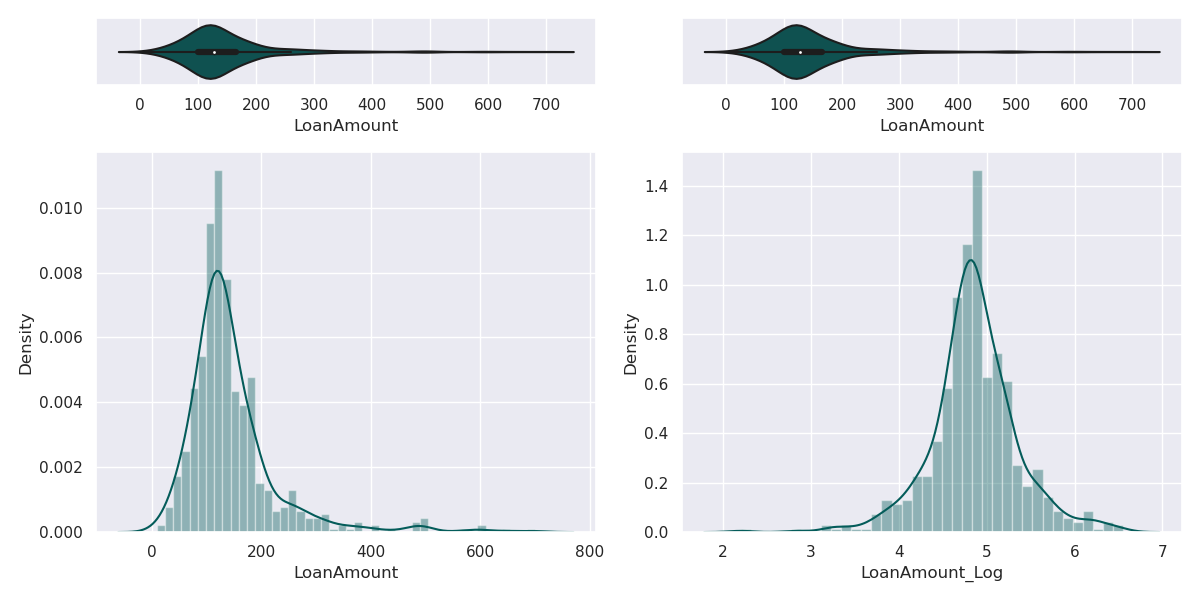

In [68]:
df_ff = df_filled_final


plt.close()

df_transform = df_ff
fig, ax = plt.subplots(2,2,figsize=(12,6), gridspec_kw={"height_ratios": (.15, .85)})
sns.violinplot(df_ff['LoanAmount'],ax=ax[0,0])
sns.distplot(df_ff['LoanAmount'],ax=ax[1,0])

df_transform['LoanAmount_Log'] = np.log(df_ff['LoanAmount'])

sns.violinplot(df_transform.LoanAmount,ax=ax[0,1])
sns.distplot(df_transform['LoanAmount_Log'],ax=ax[1,1])
plt.tight_layout()


    Combine both incomes as total income and take a log transformation of the same.

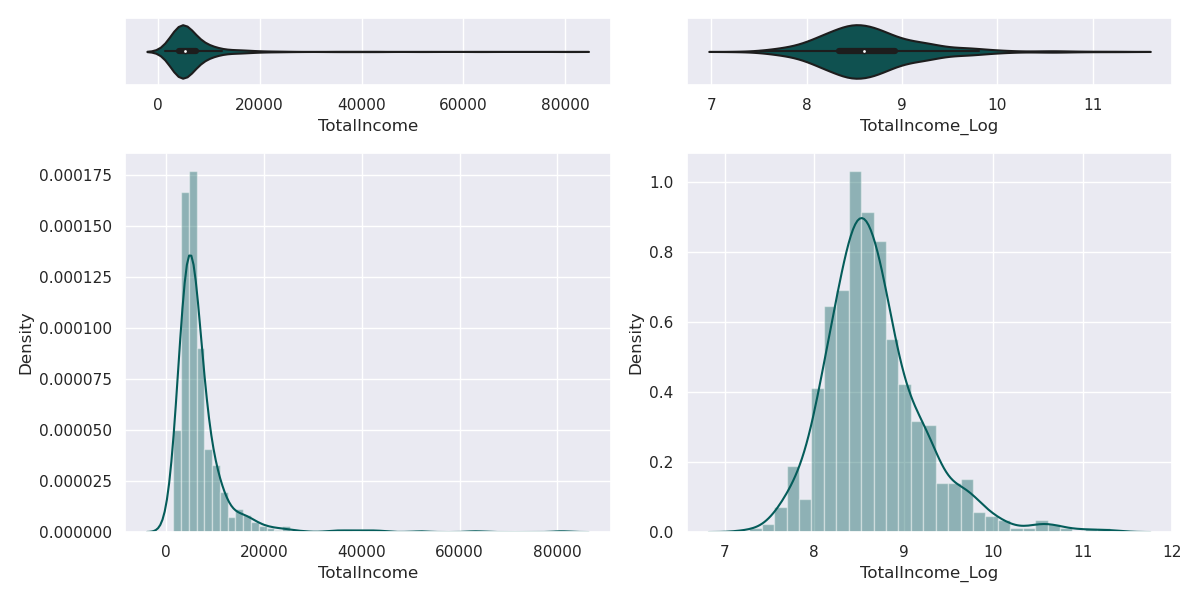

In [69]:
plt.close(fig)
fig, ax = plt.subplots(2,2,figsize=(12,6), gridspec_kw={"height_ratios": (.15, .85)})
sns.violinplot(df_ff['TotalIncome'],ax=ax[0,0])
sns.distplot(df_ff['TotalIncome'],ax=ax[1,0])
sns.set_theme(palette=sns.xkcd_palette(['dark turquoise','dark cyan','greenish blue', 'bluish green', 'moss', 'sage green']))

df_transform['ApplicantIncome_Log'] = np.log(df_ff['ApplicantIncome'])
df_transform['CoapplicantIncome_Log'] = np.log(df_ff['CoapplicantIncome'])

df_transform['TotalIncome_Log'] = np.log(df_ff['TotalIncome'])
sns.violinplot(df_transform['TotalIncome_Log'],ax=ax[0,1])
sns.distplot(df_transform['TotalIncome_Log'],ax=ax[1,1])
plt.tight_layout()

In [70]:
df_clean = df_transform.set_index('Loan_ID')
# df_clean = pd.get_dummies(df_transform.set_index('Loan_ID'))
pickle.dump(df_clean,open('df_clean.p','wb'))


## 4. Building a Predictive Model

In [71]:
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion



from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score,r2_score


from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = SGDClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

df_clean = pickle.load(open('df_clean.p','rb'))
df_clean = df_clean.reset_index(drop=True)
df_clean = df_clean.drop(['CoapplicantIncome_Log'],axis=1)

y = df_clean['Loan_Status']
X = df_clean.drop('Loan_Status',axis=1)

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.65)

In [75]:
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
# numerical_preprocessing = Pipeline([('imputation', SimpleImputer())])
scaling = Pipeline([('scaler',StandardScaler())])


# define which transformer applies to which columns
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['Property_Area','Dependents']),
    # ('numerical_preprocessing', numerical_preprocessing, ['age'])
    ('scaling', scaling, X.columns[X.dtypes != object])
])

pca = PCA(n_components=2)

# Maybe some of the original features were good, too?
selection = SelectKBest(k=3)

# Build an transformer from PCA and Univariate selection:
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
svm = SVC(kernel="linear")

rfc = RandomForestClassifier(n_estimators=100)


clfs = ClfSwitcher()

pipeline = Pipeline([('preprocess',preprocess),("features",combined_features),("clfs",clfs)])
params_clf_switch = [
    {
                      "features__pca__n_components" : [2,3,4,5,6],
                      "features__univ_select__k": [2,3,4,5,6],
                      'clfs__estimator':[SGDClassifier()],
                      'clfs__estimator__alpha': [0.001],
                      'clfs__estimator__random_state':[1738],
                      'clfs__estimator__max_iter': (10,20),
                     'clfs__estimator__tol':[None]},
                     {"features__pca__n_components" : [2,3,4,5,6],
                      "features__univ_select__k": [2,3,4,5,6],
                      'clfs__estimator':[RandomForestClassifier()],
                      'clfs__estimator__n_estimators':(50,100),
                      'clfs__estimator__max_features':('sqrt','log2'),
                     'clfs__estimator__n_jobs':[8]},
                     
                     {"features__pca__n_components" : [2,3,4,5,6],
                      "features__univ_select__k": [2,3,4,5,6],
                      'clfs__estimator':[LogisticRegression()],
                      'clfs__estimator__C':(1,2),
                      'clfs__estimator__penalty':('l2','l1','elasticnet')}
]
# now fit the pipeline using the whole dataframe
# df_features = df[['favorite_color','age']]
# df_target = df['target']
 # We will initialize the classifier

# create our pipeline from FeatureUnion 
# pipeline = Pipeline([("features", combined_features), ("svm", svm)])

# # set up our parameters grid
# param_grid = {"features__pca__n_components": [1, 2, 3,4,5,6],
#                   "features__univ_select__k": [1, 2, 3,4,5,6],
#                   "svm__C":[0.1, 1, 10]}

# # create a Grid Search object
# # grid_search = GridSearchCV(pipeline, param_grid, verbose=10, refit=True) 

# grid_search = GridSearchCV(pipeline, param_grid, refit=True)    
# # fit the model and tune parameters
# grid_search.fit(X, y)
# call fit on the dataframes
pipeline.fit(X_train,y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Property_Area',
                                                   'Dependents']),
                                                 ('scaling',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'TotalIncome', 'LoanAmount_Log', 'ApplicantIncome_Log',
       'TotalIncome_Log'],
      dtype='object'))])),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=2)),
                                                ('univ_select',
                                                 SelectKBest(k=3))])),
                ('clfs', ClfSwitcher())])

In [76]:

grid_search=GridSearchCV(pipeline,params_clf_switch,verbose=2,refit=True,n_jobs=16,scoring='accuracy',return_train_score =True)
grid_search.fit(X_train,y_train)
grid_search.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END clfs__estimator=RandomForestClassifier(), clfs__estimator__max_features=sqrt, clfs__estimator__n_estimators=50, clfs__estimator__n_jobs=8, features__pca__n_components=4, features__univ_select__k=6; total time=   0.2s
[CV] END clfs__estimator=RandomForestClassifier(), clfs__estimator__max_features=sqrt, clfs__estimator__n_estimators=50, clfs__estimator__n_jobs=8, features__pca__n_components=4, features__univ_select__k=6; total time=   0.3s
[CV] END clfs__estimator=RandomForestClassifier(), clfs__estimator__max_features=sqrt, clfs__estimator__n_estimators=50, clfs__estimator__n_jobs=8, features__pca__n_components=4, features__univ_select__k=6; total time=   0.2s
[CV] END clfs__estimator=RandomForestClassifier(), clfs__estimator__max_features=sqrt, clfs__estimator__n_estimators=100, clfs__estimator__n_jobs=8, features__pca__n_components=2, features__univ_select__k=5; total time=   0.3s
[CV] END clfs__estimator=Random

{'clfs__estimator': RandomForestClassifier(max_features='log2', n_estimators=50, n_jobs=8),
 'clfs__estimator__max_features': 'log2',
 'clfs__estimator__n_estimators': 50,
 'clfs__estimator__n_jobs': 8,
 'features__pca__n_components': 3,
 'features__univ_select__k': 5}

In [81]:

final_pipe = grid_search.best_estimator_
final_pipe.predict_proba(X_train)
print(grid_search.best_score_)

0.7995253164556961


In [84]:
final_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Property_Area',
                                                   'Dependents']),
                                                 ('scaling',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'TotalIncome', 'LoanAmount_Log', 'ApplicantIncome_Log',
       'TotalIncome_Log'],
      dtype='object'))])),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=3)),
                                                ('univ_select',
                                                 SelectKBest(k=5))])),
                ('clfs',
                 ClfSwitcher(estimator=RandomForestClassifier(max_features='log2',
                                                              n_estimators=50,
                                                              n_jobs=8)))])

In [85]:
# https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers

final_pipe.fit(X_train,y_train)
y_pred = final_pipe.predict(X_test)
accuracy_score(y_pred,y_test)

0.7627906976744186

In [124]:
import random
import json
import requests as re
json_data = X_test.reset_index(drop=True).iloc[random.sample(list(range(0,len(y_test))),1)]


In [126]:
URL = "http://ailette.tplinkdns.com:19230/scoring"
# sending get request and saving the response as response object 

json_data = json_data.to_json()
r = requests.post(url = URL, json = json_data) 

r.json

AttributeError: 'str' object has no attribute 'to_json'

In [ ]:




# classifier init
svm = SVC(kernel='linear')

# create pipeline from FeatureUnion
pipeline = Pipeline([("features",combined_features),("svm",svm)])



In [ ]:
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])

In [ ]:
preprocess = ColumnTransformer(['categorical_preprocessing',categorical_preprocessing,['Dependents','Property_Area']])

In [ ]:
pipeline = Pipeline([('preprocess',preprocess),('clf',RandomForestClassifier())])

Try parameter grid search to improve the results

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

In [ ]:
plt.close()
fig, ax = plt.subplots(1,1,figsize=(10,10))
matrix = df_filled_final.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

Try paramater grid search to improve the results

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

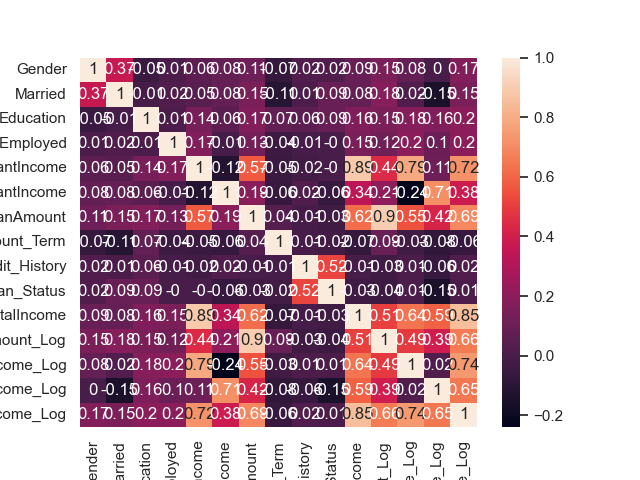

In [30]:
plt.close()
fig, ax = plt.subplots(1,1)
matrix = df_filled_final.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()